In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

# 6.1 Subset Selection

**6.1.1 Best Subset Selection**

In [3]:
Credit = pd.read_csv("data/Credit.csv").drop('Unnamed: 0',axis = 1)
Credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [4]:
Credit.isnull().sum()

Income       0
Limit        0
Rating       0
Cards        0
Age          0
Education    0
Gender       0
Student      0
Married      0
Ethnicity    0
Balance      0
dtype: int64

In [5]:
Credit.shape

(400, 11)

In [6]:
import itertools
columns_value = '1'
for column_value in Credit.columns:
    columns_value = columns_value + '+' + column_value
model = 'Balance ~ {} - Balance'.format(columns_value)
y,X = patsy.dmatrices(model, data = Credit, return_type="dataframe")

In [7]:
X.head()

,Intercept,Gender[T.Male],Student[T.Yes],Married[T.Yes],Ethnicity[T.Asian],Ethnicity[T.Caucasian],Income,Limit,Rating,Cards,Age,Education
0,1.0,1.0,0.0,1.0,0.0,1.0,14.891,3606.0,283.0,2.0,34.0,11.0
1,1.0,0.0,1.0,1.0,1.0,0.0,106.025,6645.0,483.0,3.0,82.0,15.0
2,1.0,1.0,0.0,0.0,1.0,0.0,104.593,7075.0,514.0,4.0,71.0,11.0
3,1.0,0.0,0.0,0.0,1.0,0.0,148.924,9504.0,681.0,3.0,36.0,11.0
4,1.0,1.0,0.0,1.0,0.0,1.0,55.882,4897.0,357.0,2.0,68.0,16.0


In [8]:
X_columns = list(X.columns)
#这里这么麻烦而不直接用'Balance ~  0 + ...'模型的原因是为了有截距，一个层级上的截距会被舍弃，防止出现共线性
X_columns.remove('Intercept')
nv_result_ssr = {}
nv_result_rsquared = {}
nv_ssr_min = []
nv_rsquared_max = []
for nv in range(1,len(X_columns) + 1):
    nv_result_ssr[nv] = []
    nv_result_rsquared[nv] = []
    for X_columns_nv in itertools.combinations(X_columns,nv):
        X_columns_nv = list(X_columns_nv)
        X_model = sm.add_constant(X[X_columns_nv])
        results = sm.OLS(y, X_model).fit()
        nv_result_ssr[nv].append(results.ssr)
        nv_result_rsquared[nv].append(results.rsquared)
    nv_ssr_min.append(np.min(nv_result_ssr[nv]))
    nv_rsquared_max.append(np.max(nv_result_rsquared[nv]))  

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**FIGURE 6.1.**

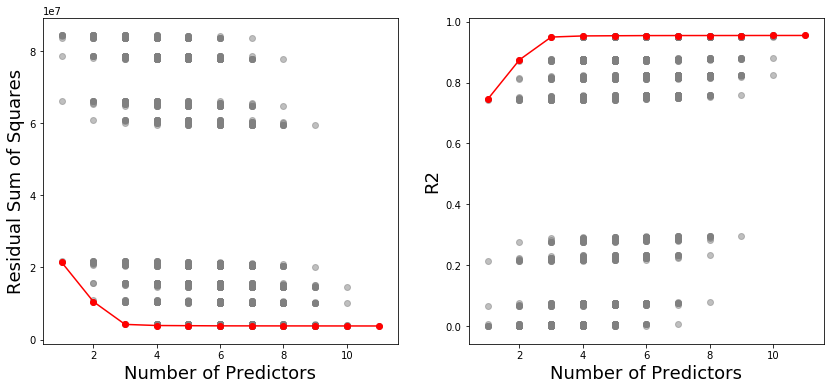

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
for nv in range(1,len(X_columns) + 1):
    plt.scatter([nv]*len(nv_result_ssr[nv]),nv_result_ssr[nv],c = 'gray',alpha=0.5)
plt.plot(range(1,len(X_columns) + 1),nv_ssr_min,'r-')
plt.scatter(range(1,len(X_columns) + 1),nv_ssr_min,marker = 'o',color = 'r')
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Residual Sum of Squares", fontsize=18)
plt.subplot(122)
for nv in range(1,len(X_columns) + 1):
    plt.scatter([nv]*len(nv_result_rsquared[nv]),nv_result_rsquared[nv],c = 'gray',alpha=0.5)
plt.plot(range(1,len(X_columns) + 1),nv_rsquared_max,'r-')
plt.scatter(range(1,len(X_columns) + 1),nv_rsquared_max, marker = 'o',color = 'r')
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"R2", fontsize=18)
plt.show()

In [10]:
#实现一个按照RSS（或者其他评估）来量化的regsubsets函数
def regsubsets(model,dataset,nvmax = 8,method = 'full',scale = 'rss'):
    y,X = patsy.dmatrices(model, data = dataset, return_type="dataframe")
    X_columns = list(X.columns)
    try:
        X_columns.remove('Intercept')
    except:
        pass
    if nvmax > len(X_columns):
        nvmax = len(X_columns)
    all_data_dict = {}
    if method == 'full':
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            for X_columns_nv in itertools.combinations(X_columns,nv):
                X_columns_nv = list(X_columns_nv)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
    elif method == 'forward':
        all_data_dict[0] = {}
        all_data_dict[0]['X_columns'] = []
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            X_columns_others = X_columns.copy()
            for column_value in all_data_dict[nv - 1]['X_columns']:
                X_columns_others.remove(column_value)
            for column_value in X_columns_others:
                X_columns_nv = all_data_dict[nv - 1]['X_columns'].copy()
                X_columns_nv.append(column_value)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        del all_data_dict[0]
    elif method == 'backward':
        for nv in reversed(range(1,len(X_columns) + 1)):
            nv_scale = None
            nv_result = {}
            if nv == len(X_columns):
                nv_X_columns = X_columns
            else:
                for column_value in all_data_dict[nv + 1]['X_columns']:
                    X_columns_nv = all_data_dict[nv + 1]['X_columns'].copy()
                    X_columns_nv.remove(column_value)
                    X_model = sm.add_constant(X[X_columns_nv])
                    results = sm.OLS(y, X_model).fit()
                    nv_result['rss'] = results.ssr
                    nv_result['rsq'] = -results.rsquared
                    nv_result['adjr2'] = -results.rsquared_adj
                    nv_result['cp'] = results.aic
                    nv_result['bic'] = results.bic
                    if nv_scale == None or nv_scale > nv_result[scale]:
                        nv_scale = nv_result[scale]
                        nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
            for nv in range(nvmax + 1,len(X_columns) + 1):
                del all_data_dict[nv]
    return pd.DataFrame(all_data_dict).T.sort_index()

In [11]:
reg_full_d4 = regsubsets(model,Credit,nvmax = 4,method = 'full',scale = 'rss')
reg_forward_d4 = regsubsets(model,Credit,nvmax = 4,method = 'forward',scale = 'rss')

In [12]:
reg_full_d4

,X_columns,rss,rsq,adjr2,cp,bic,params
1,[Rating],2.14351e+07,0.745848,0.74521,5494.78,5502.76,const -390.846342 Rating 2.566240 dtyp...
2,"[Income, Rating]",1.05325e+07,0.875118,0.874489,5212.56,5224.53,const -534.812150 Income -7.672124 Rati...
3,"[Student[T.Yes], Income, Rating]",4.22722e+06,0.949879,0.949499,4849.39,4865.35,const -581.078888 Student[T.Yes] ...
4,"[Student[T.Yes], Income, Limit, Cards]",3.91506e+06,0.95358,0.95311,4820.7,4840.66,const -499.727212 Student[T.Yes] ...


In [13]:
reg_forward_d4

,X_columns,rss,rsq,adjr2,cp,bic,params
1,[Rating],2.14351e+07,0.745848,0.74521,5494.78,5502.76,const -390.846342 Rating 2.566240 dtyp...
2,"[Rating, Income]",1.05325e+07,0.875118,0.874489,5212.56,5224.53,const -534.812150 Rating 3.949265 Inco...
3,"[Rating, Income, Student[T.Yes]]",4.22722e+06,0.949879,0.949499,4849.39,4865.35,const -581.078888 Rating ...
4,"[Rating, Income, Student[T.Yes], Limit]",4.0325e+06,0.952188,0.951703,4832.52,4852.48,const -516.718261 Rating ...


**TABLE 6.1**

In [14]:
table_6_1 = pd.DataFrame({'变量个数':range(1,5),'最优子集选择':reg_full_d4['X_columns'],'向前逐步选择':reg_forward_d4['X_columns']})
table_6_1.set_index('变量个数')

,最优子集选择,向前逐步选择
变量个数,,
1,[Rating],[Rating]
2,"[Income, Rating]","[Rating, Income]"
3,"[Student[T.Yes], Income, Rating]","[Rating, Income, Student[T.Yes]]"
4,"[Student[T.Yes], Income, Limit, Cards]","[Rating, Income, Student[T.Yes], Limit]"


In [15]:
reg_full_cp = regsubsets(model,Credit,nvmax = 11,method = 'full',scale = 'cp')
reg_full_bic = regsubsets(model,Credit,nvmax = 11,method = 'full',scale = 'bic')
reg_full_adjr2 = regsubsets(model,Credit,nvmax = 11,method = 'full',scale = 'adjr2')

**FIGURE 6.2.**

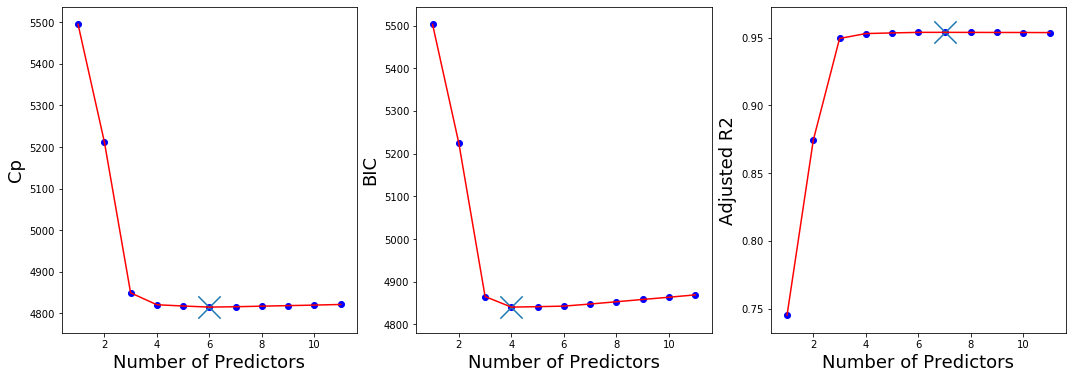

In [16]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(1,len(X_columns) + 1),reg_full_cp['cp'],'r-')
plt.scatter(range(1,len(X_columns) + 1 ),reg_full_cp['cp'],color = 'b')
plt.scatter(reg_full_cp['cp'].astype('float64').idxmin(),reg_full_cp['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.subplot(132)
plt.plot(range(1,len(X_columns) + 1),reg_full_bic['bic'],'r-')
plt.scatter(range(1,len(X_columns)+ 1 ),reg_full_bic['bic'],color = 'b')
plt.scatter(reg_full_bic['bic'].astype('float64').idxmin(),reg_full_bic['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.subplot(133)
plt.plot(range(1,len(X_columns) + 1),reg_full_adjr2['adjr2'],'r-')
plt.scatter(range(1,len(X_columns) + 1),reg_full_adjr2['adjr2'],color = 'b')
plt.scatter(reg_full_adjr2['adjr2'].astype('float64').idxmax(),reg_full_adjr2['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.show()

In [17]:
reg_full_cp['X_columns'][reg_full_cp['cp'].astype('float64').idxmin()]

['Student[T.Yes]', 'Income', 'Limit', 'Rating', 'Cards', 'Age']

In [18]:
reg_full_bic['X_columns'][reg_full_bic['bic'].astype('float64').idxmin()]

['Student[T.Yes]', 'Income', 'Limit', 'Cards']

In [19]:
reg_full_adjr2['X_columns'][reg_full_adjr2['adjr2'].astype('float64').idxmax()]

['Gender[T.Male]',
 'Student[T.Yes]',
 'Income',
 'Limit',
 'Rating',
 'Cards',
 'Age']

**验证与交叉验证**

In [20]:
#定一个根据模型、测试集、训练集求验证误差的函数
def regfit_var_errors(regfit,train_set,test_set,model):
    nvmax = len(regfit)
    y_train ,X_train = patsy.dmatrices(model,train_set, return_type="dataframe")
    y_test ,X_test = patsy.dmatrices(model,test_set, return_type="dataframe")
    var_errors = {}
    for nv in range(1,nvmax + 1):
        X_train_model = sm.add_constant(X_train[regfit['X_columns'][nv]])
        results = sm.OLS(y_train,X_train_model).fit()
        predict_test = results.predict(sm.add_constant(X_test[regfit['X_columns'][nv]]))
        var_errors[nv] = ((np.c_[y_test].ravel() - predict_test)**2).mean()     
    return pd.DataFrame(var_errors,index = ['var_errors']).round().T

In [21]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Credit, test_size = 0.25, random_state = 1)
reg_train_rss = regsubsets(model,train_set,nvmax = 11,method = 'full',scale = 'rss')
reg_split = regfit_var_errors(reg_train_rss,train_set,test_set,model)
reg_split

,var_errors
1,69356.0
2,30844.0
3,12943.0
4,11840.0
5,11006.0
6,11191.0
7,11363.0
8,11529.0
9,11496.0
10,11469.0


In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=1,shuffle=True)
kf.get_n_splits(Credit)

10

In [23]:
var_errors_kf = pd.DataFrame()
kf_idx = 1
for train_index, test_index in kf.split(Credit):
    reg_cv_rss = regsubsets(model, Credit.iloc[train_index],nvmax = 11,method = 'full',scale = 'rss')
    var_errors = regfit_var_errors(reg_cv_rss, Credit.iloc[train_index],Credit.iloc[test_index],model)
    var_errors_kf['kf_idx{}'.format(kf_idx)] = var_errors['var_errors']
    kf_idx += 1
reg_cv = var_errors_kf.T.mean()
reg_cv

1     53978.0
2     27018.0
3     10931.2
4     10180.8
5     10237.4
6     10066.4
7     10201.6
8     10260.6
9     10300.3
10    10246.5
11    10159.1
dtype: float64

**FIGURE 6.3.**

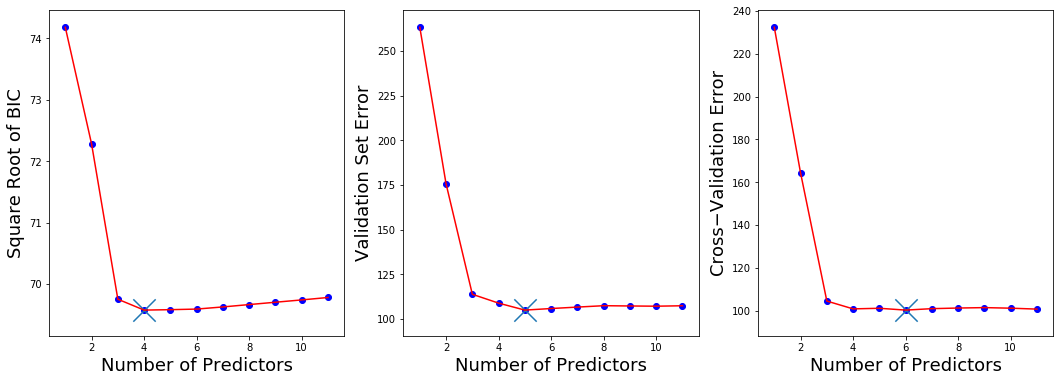

In [24]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(1,len(X_columns) + 1),reg_full_bic['bic'] ** 0.5,'r-')
plt.scatter(range(1,len(X_columns) + 1),reg_full_bic['bic'] ** 0.5,color = 'b')
plt.scatter(reg_full_bic['bic'].astype('float64').idxmin(),reg_full_bic['bic'].min() ** 0.5,marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Square Root of BIC", fontsize=18)
plt.subplot(132)
plt.plot(range(1,len(X_columns) + 1),reg_split['var_errors'] ** 0.5,'r-')
plt.scatter(range(1,len(X_columns) + 1),reg_split['var_errors'] ** 0.5,color = 'b')
plt.scatter(reg_split['var_errors'].astype('float64').idxmin(),reg_split['var_errors'].min() ** 0.5,marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Validation Set Error", fontsize=18)
plt.subplot(133)
plt.plot(range(1,len(X_columns) + 1),reg_cv ** 0.5,'r-')
plt.scatter(range(1,len(X_columns) + 1),reg_cv ** 0.5 ,color = 'b')
plt.scatter(reg_cv.idxmin(),reg_cv.min() ** 0.5,marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cross−Validation Error", fontsize=18)
plt.show()

# 6.2 Shrinkage Methods

**6.2.1 Ridge Regression**

In [25]:
X.drop('Intercept',axis = 1,inplace = True)

In [26]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
grid = 10 ** np.linspace(-2, 6, 1000)
def get_shrinkage_mod(X,y,grid,methods = 1,return_type = 1):
    std_scaler = StandardScaler(with_mean = False)
    std_scaler.fit(X)
    X_Standard = std_scaler.transform(X)
    shrinkage_mod =  []
    idx = 1
    shrinkage_mod_columns = [['idx','lambda','coef'],['','','Intercept']]
    for variable in X.columns:
        shrinkage_mod_columns[0].append('coef')
        shrinkage_mod_columns[1].append(variable)
    for alpha in grid:
        if methods == 1:
            shrinkage_reg = Ridge(alpha = alpha)
        else:
            shrinkage_reg = Lasso(alpha = alpha)           
        shrinkage_reg.fit(X_Standard,y)
        shrinkage_mod.append([])
        shrinkage_mod[idx - 1].append(idx)
        shrinkage_mod[idx - 1].append(alpha)
        shrinkage_mod[idx - 1].append(shrinkage_reg.intercept_[0])
        #return_type为1返回Standardized Coefficients，否则反馈原模型的Coefficients
        if return_type == 1:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_[0])
            else:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_)
        else:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_[0].reshape(1,-1))[0].tolist())
            else:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_.reshape(1,-1))[0].tolist())
        idx += 1
    return  pd.DataFrame(np.array(shrinkage_mod),columns = shrinkage_mod_columns).set_index('idx')
ridge_mod = get_shrinkage_mod(X,y,grid)

In [27]:
#求l2范数
std_scaler = StandardScaler(with_mean = False)
std_scaler.fit(X)
X_Standard = std_scaler.transform(X)
X_model = sm.add_constant(X)
results = sm.OLS(y, X).fit()
ell_2 = ((results.params[1:] ** 2).sum()) ** 0.5
ell_2_lambda = (ridge_mod['coef'].iloc[:,1:] ** 2).sum(axis = 1) ** 0.5
ell_division_list = ell_2_lambda/ell_2

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**FIGURE 6.4.**

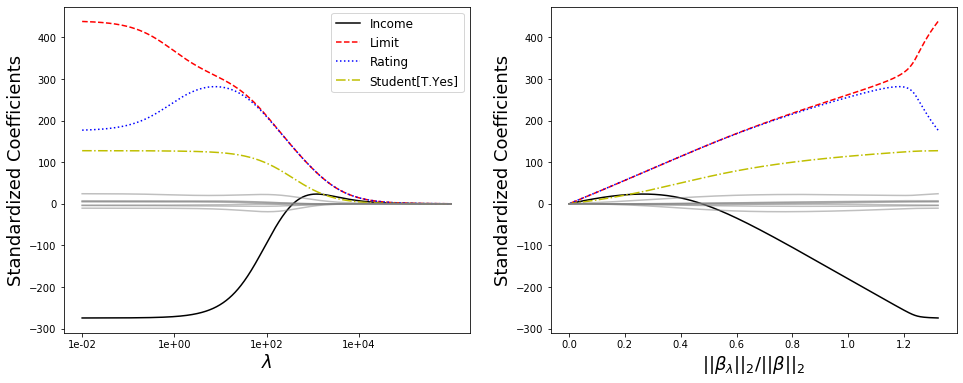

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
coef_select = ['Income','Limit','Rating','Student[T.Yes]']
coef_select_style = ['black','r--','b:','y-.']
coef_idx = 0
for coef in coef_select:
    plt.plot(np.linspace(-2, 6, 1000),ridge_mod['coef'][coef],coef_select_style[coef_idx],label= coef)
    coef_idx += 1
for coef in X.columns:
    if coef not in coef_select:
        plt.plot(np.linspace(-2, 6, 1000),ridge_mod['coef'][coef],'gray',alpha = 0.5)
lables = ['1e-02','1e+00','1e+02','1e+04']
plt.xticks(np.linspace(-2,4,4),lables)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(u"Standardized Coefficients", fontsize=18)
plt.legend(loc='upper right', fontsize=12)
plt.subplot(122)
coef_idx = 0
for coef in coef_select:
    plt.plot(ell_division_list,ridge_mod['coef'][coef],coef_select_style[coef_idx])
    coef_idx += 1
for coef in X.columns:
    if coef not in coef_select:
        plt.plot(ell_division_list,ridge_mod['coef'][coef],'gray',alpha = 0.5)
plt.xlabel(r"$||\beta_\lambda||_2 / ||\beta||_2$", fontsize=18)
plt.ylabel(u"Standardized Coefficients", fontsize=18)
plt.show()

**6.2.2 lasso**

In [29]:
grid = 10 ** np.linspace(0.3, 2.7, 100)
lasso_mod = get_shrinkage_mod(X,y,grid,methods = 2)
#求lasso l1范数
ell_1 = results.params[1:].abs().sum()
ell_1_lambda = lasso_mod['coef'].iloc[:,1:].abs().sum(axis = 1)
ell_division_list = ell_1_lambda/ell_1

**FIGURE 6.6.**

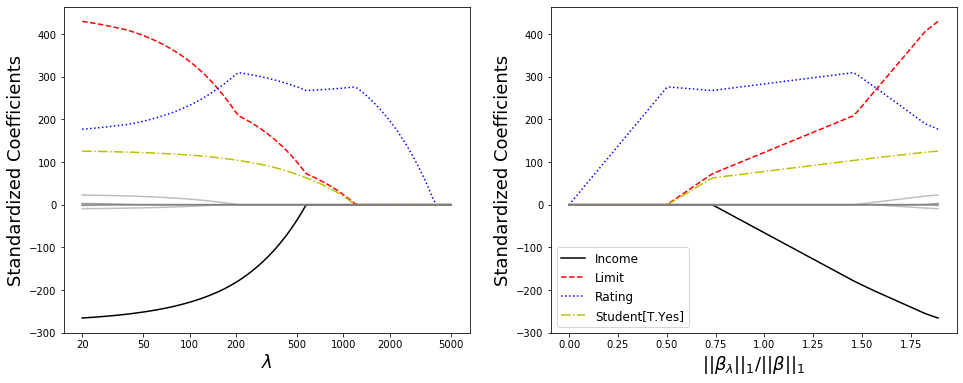

In [30]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
coef_select = ['Income','Limit','Rating','Student[T.Yes]']
coef_select_style = ['black','r--','b:','y-.']
coef_idx = 0
for coef in coef_select:
    plt.plot(np.linspace(0.3, 2.7, 100),lasso_mod['coef'][coef],coef_select_style[coef_idx])
    coef_idx += 1
for coef in X.columns:
    if coef not in coef_select:
        plt.plot(np.linspace(0.3, 2.7, 100),lasso_mod['coef'][coef],'gray',alpha = 0.5)
lables = [20,50,100,200,500,1000,2000,5000]
#没有弄清楚sklearn的alpha与R中lambda的对应关系，这里除10后与原图对应关系较好
ticks = np.log10(np.array(lables)/10)
plt.xticks(ticks,lables)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(u"Standardized Coefficients", fontsize=18)
plt.subplot(122)
coef_idx = 0
for coef in coef_select:
    plt.plot(ell_division_list,lasso_mod['coef'][coef],coef_select_style[coef_idx],label= coef)
    coef_idx += 1
for coef in X.columns:
    if coef not in coef_select:
        plt.plot(ell_division_list,lasso_mod['coef'][coef],'gray',alpha = 0.5)
plt.legend(loc='lower left', fontsize=12)
plt.xlabel(r"$||\beta_\lambda||_1 / ||\beta||_1$", fontsize=18)
plt.ylabel(u"Standardized Coefficients", fontsize=18)
plt.show()

**6.2.3 Selecting the Tuning Parameter**

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'alpha': 5 * 10 ** np.linspace(-3, 0, 100) },
]
ridge_reg = Ridge(random_state = 1)
grid_search = GridSearchCV(ridge_reg, param_grid, cv = len(y), scoring='neg_mean_squared_error')
grid_search.fit(X_Standard ,y)

GridSearchCV(cv=400, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([0.005     , 0.00536134, 0.00574878, 0.00616423, 0.00660971,
       0.00708737, 0.00759956, 0.00814875, 0.00873764, 0.00936909,
       0.01004617, 0.01077217, 0.0...
       0.93690871, 1.0046165 , 1.07721735, 1.15506485, 1.23853818,
       1.32804389, 1.42401793, 1.52692775, 1.63727458, 1.75559587,
       1.8824679 , 2.01850863, 2.16438064, 2.32079442, 2.48851178,
       2.66834962, 2.86118383, 3.06795364, 3.28966612, 3.52740116,
       3.78231664, 4.05565415, 4.34874501, 4.66301673, 5.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [32]:
lambda_best = np.log10(grid_search.best_params_['alpha']/5)

In [33]:
grid = 5 * 10 ** np.linspace(-3, 0, 100)
ridge_mod = get_shrinkage_mod(X,y,grid)

**FIGURE 6.12.**

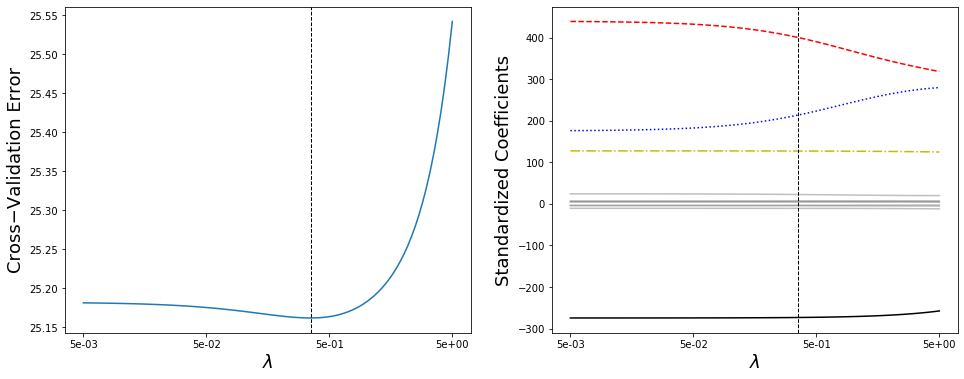

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(np.linspace(-3, 0, 100),-grid_search.cv_results_["mean_test_score"]/len(y))
plt.axvline(x = lambda_best,linewidth = 1 ,ls = '--',color = 'black')
lables = ['5e-03','5e-02','5e-01','5e+00']
plt.xticks(np.linspace(-3,0,4),lables)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(u"Cross−Validation Error", fontsize=18)
plt.subplot(122)
coef_idx = 0
for coef in coef_select:
    plt.plot(np.linspace(-3, 0, 100),ridge_mod['coef'][coef],coef_select_style[coef_idx])
    coef_idx += 1
for coef in X.columns:
    if coef not in coef_select:
        plt.plot(np.linspace(-3, 0, 100),ridge_mod['coef'][coef],'gray',alpha = 0.5)
plt.axvline(x = lambda_best,linewidth = 1 ,ls = '--',color = 'black')
plt.xticks(np.linspace(-3,0,4),lables)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(u"Standardized Coefficients", fontsize=18)
plt.show()

# 6.3 Dimension Reduction Methods

**6.3.1 Principal Components Regression**

In [35]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pca_lr = Pipeline([
("pca", PCA()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'pca__n_components': np.arange(1,12) },
]
grid_search = GridSearchCV(pca_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_Standard ,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])}],
 

In [36]:
for N in range(1,12):
    pca = PCA(n_components= N)
    XND = pca.fit_transform(X_Standard)
    lr = linear_model.LinearRegression()
    lr.fit(XND,y)
    if N == 1:
        coef_arr = lr.coef_.dot(pca.components_)
    else:
        coef_arr = np.concatenate([coef_arr, lr.coef_.dot(pca.components_)], axis=0)
coef_pd = pd.DataFrame(coef_arr,columns = X.columns)

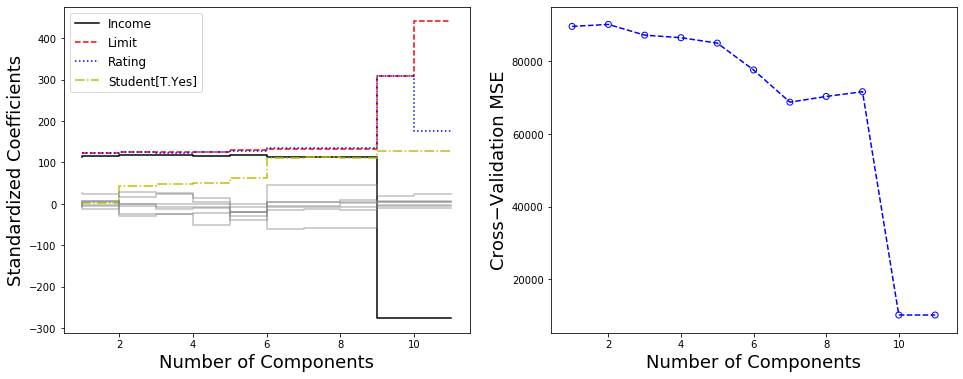

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
coef_idx = 0
lin_handles = []
linestyle_list = ['-','--',':','-.']
for coef in coef_select:
    plt.step(range(1,12) ,coef_pd[coef],coef_select_style[coef_idx],linestyle= linestyle_list[coef_idx],label = coef)
    coef_idx += 1
for coef in X.columns:
    if coef not in coef_select:
        plt.step(range(1,12), coef_pd[coef] , 'gray',alpha = 0.5)
plt.xticks(np.linspace(2,10,5))
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("Number of Components", fontsize=18)
plt.ylabel(u"Standardized Coefficients", fontsize=18)
plt.subplot(122)
mean_score_list = -grid_search.cv_results_["mean_test_score"]
plt.plot(range(1,12),mean_score_list,'b--')
plt.scatter(range(1,12),mean_score_list, marker = 'o',color = '',edgecolor = 'b')
plt.xticks(np.linspace(2, 10, 5))
plt.yticks(np.linspace(20000, 80000, 4))
plt.xlabel("Number of Components", fontsize=18)
plt.ylabel(u"Cross−Validation MSE", fontsize=18)
plt.show()